### Result of time complexity

In [1]:
import os

import pandas as pd

In [2]:
result_dir = './ibmq_result/time_complexity'


df = pd.DataFrame([])

df = pd.concat([df, pd.read_csv(os.path.join(result_dir, 'ibm_nazca_Q100.csv'))])
df = pd.concat([df, pd.read_csv(os.path.join(result_dir, 'ibm_strasbourg_Q100.csv'))])

df_mean = df.groupby(['backend', 'n_I', 'n_L', 'n_R'])['job_runtime'].mean()

In [3]:
def ibmq_gate_time(backend: str):
    # Order of df.groupby indices: 'backend', 'n_I', 'n_L', 'n_R'

    print(f"{'-' * 30} {backend} {'-' * 30}\n")

    for n_I in [1, 2, 3]:
        max_n_R = 10
        max_n_L = 10
        t_prep = df_mean[backend][n_I][0][0]
        t_enc = (df_mean[backend][n_I][0][max_n_R] - df_mean[backend][n_I][0][0]) / max_n_R
        t_vqc = (df_mean[backend][n_I][max_n_L][max_n_R] - df_mean[backend][n_I][0][max_n_R]) / max_n_L / max_n_R
        # print(f"* n_I = {n_I}: t_enc = {t_enc:6.3f} per particle | t_vqc = {t_vqc:.3f} per strongly entangling layer")

        for n_L, n_R in [(0, 0), (0, 10), (10, 10)]:
            t_total = df_mean[backend][n_I][n_L][n_R]
            t_gate = t_total - t_prep
            # print(f"- (n_L, n_R) = ({n_L:2d}, {n_R:2d}): t_prep = {t_prep:.3f} | t_gate = {t_gate:6.3f} | t_total = {t_total:6.3f}")
            print(f"{backend} & {2**n_I} & {n_I} & {n_L} & {n_R} & {t_enc:.3f} & {t_vqc:.3f} & {t_gate:.3f}")

        print()

ibmq_gate_time(backend='ibm_nazca')
ibmq_gate_time(backend='ibm_strasbourg')

------------------------------ ibm_nazca ------------------------------

ibm_nazca & 2 & 1 & 0 & 0 & 2.567 & 0.209 & 0.000
ibm_nazca & 2 & 1 & 0 & 10 & 2.567 & 0.209 & 25.670
ibm_nazca & 2 & 1 & 10 & 10 & 2.567 & 0.209 & 46.593

ibm_nazca & 4 & 2 & 0 & 0 & 5.352 & 0.197 & 0.000
ibm_nazca & 4 & 2 & 0 & 10 & 5.352 & 0.197 & 53.525
ibm_nazca & 4 & 2 & 10 & 10 & 5.352 & 0.197 & 73.239

ibm_nazca & 8 & 3 & 0 & 0 & 10.551 & 0.219 & 0.000
ibm_nazca & 8 & 3 & 0 & 10 & 10.551 & 0.219 & 105.508
ibm_nazca & 8 & 3 & 10 & 10 & 10.551 & 0.219 & 127.439

------------------------------ ibm_strasbourg ------------------------------

ibm_strasbourg & 2 & 1 & 0 & 0 & 2.595 & 0.217 & 0.000
ibm_strasbourg & 2 & 1 & 0 & 10 & 2.595 & 0.217 & 25.953
ibm_strasbourg & 2 & 1 & 10 & 10 & 2.595 & 0.217 & 47.614

ibm_strasbourg & 4 & 2 & 0 & 0 & 5.416 & 0.197 & 0.000
ibm_strasbourg & 4 & 2 & 0 & 10 & 5.416 & 0.197 & 54.155
ibm_strasbourg & 4 & 2 & 10 & 10 & 5.416 & 0.197 & 73.870

ibm_strasbourg & 8 & 3 & 0 & 0 & 1

### Result of pretrained model and noise estimation

In [4]:
from itertools import product
import os

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import seaborn as sns

sns.set_theme()

font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'  # Replace with the actual path
font_properties = FontProperties(fname=font_path, size=12)

In [5]:
backend = 'ibm_brussels'
noise_prob_list = [0, 1E-5, 1E-4, 1E-3, 1E-2]
x_tick_list = ['0', r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", 'IBMQ']

df = pd.DataFrame([])

for n_Q, rnd_seed in product([3, 6], range(5)):
    # IBMQ result
    _df = pd.read_csv(os.path.join('ibmq_result', 'pretrained', f"IBMQ-{backend}-Q{n_Q}-{rnd_seed}", 'version_0', 'metrics.csv'))
    _df = _df.assign(noise_prob='IBMQ', rnd_seed=rnd_seed, n_Q=int(n_Q))
    df = pd.concat([df, _df])

    # Noisy quantum circuit simulation
    for i, noise_prob in enumerate(noise_prob_list):
        _df = pd.read_csv(os.path.join('ibmq_result', 'noise', f"Noise_{noise_prob:.0e}-Q{n_Q}-{rnd_seed}", 'version_0', 'metrics.csv'))
        _df = _df.assign(noise_prob=x_tick_list[i], rnd_seed=rnd_seed, n_Q=int(n_Q))
        df = pd.concat([df, _df])

df.head(5)

,epoch,step,test_accuracy,test_auc,noise_prob,rnd_seed,n_Q
0,0,0,0.4975,0.497963,IBMQ,0,3
0,0,0,0.7375,0.812500,0,0,3
0,0,0,0.7050,0.779600,$10^{-5}$,0,3
0,0,0,0.7225,0.801175,$10^{-4}$,0,3
0,0,0,0.7050,0.781975,$10^{-3}$,0,3


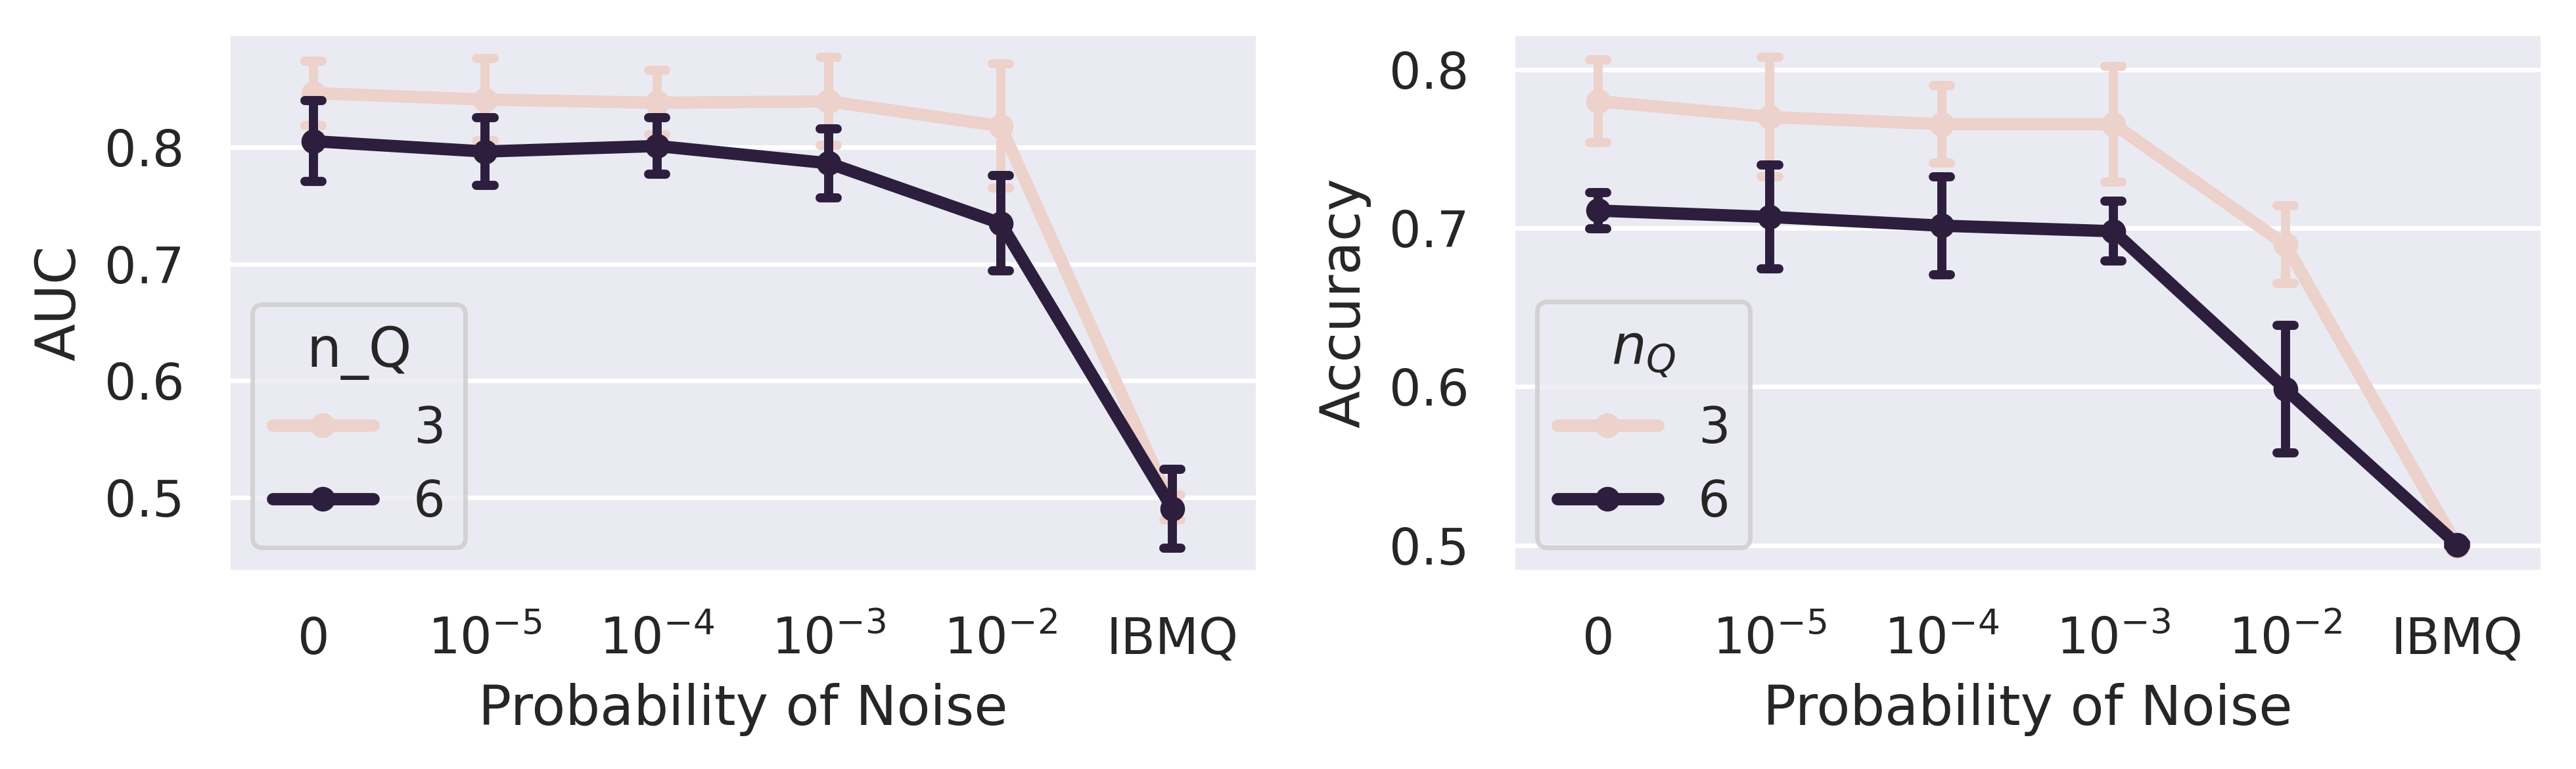

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), dpi=500)
# fig.suptitle(r"Noise Extrapolation of 4-Particle Top-QCD Jets ($n_I=2$) on Pre-trained QCGNN", fontsize=12)

def plot_noise_extrapolation(ax: plt.Axes, metric: str, y_label: str):
    sns.pointplot(
        data=df, x='noise_prob', y=metric, ax=ax, order=x_tick_list, hue='n_Q',
        marker='.', err_kws={'linewidth': 2}, capsize=0.1, errorbar=('sd', 1),
    )

    ax.set_xlabel('Probability of Noise')
    ax.set_ylabel(y_label)

plot_noise_extrapolation(ax[0], 'test_auc', 'AUC')
plot_noise_extrapolation(ax[1], 'test_accuracy', 'Accuracy')

plt.legend(title=r"$n_Q$", loc='lower left')
plt.tight_layout()